# Assignment 5: Neuroevolution

**Goal**: Implement an Evolutionary Algorithm to optimize an Artificial Neural Network (ANN) based controller for the CartPole task in OpenAI Gym environment.

CartPole evaluation environment functions are provided. Your goal is to implement your ANN to control the cartpole and use your Evolutionary Algorithm to optimize the ANN parameters (weights).

Please answer the `Questions` and implement coding `Tasks` by filling **PLEASE FILL IN** sections. *Documentation* of your code is also important. You can find the grading scheme in implementation cells.

  * Plagiarism is automatically checked and set to **0 points**

  * It is allowed to learn from external resources but copying is not allowed. If you use any external resource, please cite them in the comments (e.g. `# source: https://...../` (see `fitness_function`))

**Install Prerequisites**

In [1]:
# Run this cell to install the required libraries
%pip install numpy matplotlib scipy torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

**Imports**

In [4]:
# Necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List, Dict, Callable
import random
import math


In [5]:
# Enables inline matplotib graphs
%matplotlib inline

# Comment the line above and uncomment the lines below to have interactive plots
# WARN: may cause dependency issues
# %matplotlib qt5
# %pip install PyQt5
# plt.ion()

In [6]:
%pip install gymnasium
import gymnasium as gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.3 MB/s eta 0:00:00


---
**Question 1 (0-0.25-0.5 pt):** Following link provides more information about the CartPole environemnt we would like to find an ANN to control: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Please have a look at the link and note the observation and action spaces, how many dimensions they have? Are they continous or discrete, and what kinds of value they can get?

**Answer:**  <br>
**Observation space:**
* dims = 4
* continuous
* values:
  * Cart position: Min = -4,8, Max = 4,8
  * Cart velocity: Min = -inf, Max = inf
  * Pole angle: Min = -0.418 rad (-24°), Max = 0.418 rad (24°)
  * Pole angular velocity: -Min = -inf, Max = inf
  
**action space:**
* dims = 1
* discrete
* values:
  * Direction of force (left/right): 0 or 1

---
**Question 2 (0-0.25-0.5 pt):** What is your proposed ANN architecture and why? Please also discuss the activation functions you choose.

**Answer:** I used the following architecture:
* **Input layer of size 4** to match the four input variables cart position, cart velocity, pole angle and pole velocity.
* **Hidden layer of size 6 with ReLU activation** to enhance the learning capacity without overfitting. The ReLU is chosen to introduce non-linearity and for computational efficiency.
* **output layer of size 2** to account for two possible actions (left or right).



---
**Task 1: Implementation of Evolutionary Algrotihm (0-1.6-3.8-4.2-5 pt):** Implement your evolutionary algorithm to find an ANN controller for the CartPole task.

In [7]:
#################################
# Grading
# 0 pts if the code does not work, code works but it is fundamentally incorrect
# 1.6 pts if the code works but some functions are incorrect and it is badly explained
# 3.8 pts if the code works but some functions are incorrect but it is explained well
# 4.2 pts if the code works very well aligned with the task without any mistakes, but it is badly explained
# 5 pts if the code works very well aligned with the task without any mistakes, and it is well explained
################################################################


# Artificial Neural Network parameters (weights)
# See here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for input and output space
# PLEASE SPECIFY BELOW
inp = 4 # Number of input neurons
hid = 6 # Number of hidden neurons
out = 2 # Nubmer of output neurons
###################



#Open AI gym environment
env = gym.make("CartPole-v1")

class ANN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(ANN, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size) # Input layer
    self.layer2 = nn.Linear(hidden_size, output_size) # Hidden layer
    self.activation = nn.ReLU() # Activation function hidden layer

  def forward(self, input):
    # forward pass through ANN
    x = self.activation(self.layer1(input))
    action_prob = self.layer2(x)
    return action_prob

  def set_weights(self, individual):
    start = 0 # start index for slicing

    # Set weights for layer1
    # Count layer weights and add to start to calculate end index
    end = start + self.layer1.weight.numel()
    # Extract the weights from the individual and reshape match the size of the weights of layer 1
    layer1_weights = individual[start:end].reshape(self.layer1.weight.size())
    # Assign the reshaped weights to the weight data of layer1.
    self.layer1.weight.data = torch.tensor(layer1_weights, dtype=torch.float32)

    # Repeat steps for bias and other layers
    # Set bias for layer 1
    start = end
    end = start + self.layer1.bias.numel()
    layer1_bias = individual[start:end].reshape(self.layer1.bias.size())
    self.layer1.bias.data = torch.tensor(layer1_bias, dtype=torch.float32)

    # Set weights for layer2
    start = end
    end = start + self.layer2.weight.numel()
    layer2_weights = individual[start:end].reshape(self.layer2.weight.size())
    self.layer2.weight.data = torch.tensor(layer2_weights, dtype=torch.float32)

    # Set bias for layer2
    start = end
    end = start + self.layer2.bias.numel()
    layer2_bias = individual[start:end].reshape(self.layer2.bias.size())
    self.layer2.bias.data = torch.tensor(layer2_bias, dtype=torch.float32)


# CartPole evaluation function
def cartpole(x):

    ###########
    # PLEASE FILL IN
    # Hint: x is an individual in evolutionary algorithms and needs to map to the connection weights of ANNs
    model = ANN(4,6,2)
    model.set_weights(x)
    #########

    # Reset environment
    observation, info = env.reset(seed = 0)

    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done:

      ###################
      # PLEASE FILL IN
      # Hint: Provide input to ANN and find the output to be the action
      input = torch.tensor(observation, dtype=torch.float32)
      action_prob = model.forward(input)
      action = torch.argmax(action_prob).item()
      # print(action)
      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward
      if rew > maxStep:
        done = True
      # print(action)
      # print(rew)

    env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)



# CartPole evaluation function with video recording
def cartpole_record_video(x):
    tmp_env = gym.make("CartPole-v1", render_mode="rgb_array")

    # Video recording function - be sure to check the folder path - you should see the video here:content/video/cartpole
    env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="content/video/cartpole", name_prefix="cartpole")

    ###########
    # PLEASE FILL IN
    # Hint: x is an individual in evolutionary algorithms and needs to map to the connection weights of ANNs
    model = ANN(4,6,2)
    model.set_weights(x)
    #########


    # Reset environment
    observation, info = env.reset(seed = 0)

    env.start_video_recorder()


    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done: # run nStep number of time

      ###################
      # PLEASE FILL IN
      # Hint: Provide input to ANN and find the output to be the action

      input = torch.tensor(observation, dtype=torch.float32)
      action_prob = model.forward(input)
      action = torch.argmax(action_prob).item()



      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward
      env.render()
      if rew > maxStep:
        done = True
    env.close_video_recorder()
    env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)




# Implement your Evolutionary Algorithm to find the ANN weigths that can balance the CartPole
# Feel free to add any functions, such as initialization, crossover, etc.. to make it work!

#Initialize a population randomly based on the population size and dimensions
def initialization(population_size, input_size, hidden_size, output_size) -> np.ndarray:
    """
    Initialize the starting population with random individuals.
    Each gene of an individual corresponds to a point on a dimension in the function
    """
    num_weights = (input_size + 1) * hidden_size + (hidden_size + 1) * output_size

    ################################################################
    # Generates 2d numpy array where the population size equals the number
    # of rows and the number of weights equals the number of columns
    x = np.random.uniform(low=-1.0, high=1.0, size=(population_size, num_weights))


    ################################################################

    return x # return population

def evaluation(x: np.ndarray, objective_function: Callable[[np.ndarray], float]) -> np.ndarray:
    """Evaluate the fitness of the population members"""

    ################################################################
    fitness:List[float] = [] # empty list
    # Loops through the population and calculates the objective function for
    # each individual.
    for individual in x:
      fitness_ind: float = objective_function(individual)
      fitness.append(fitness_ind)

    ################################################################
    return np.array(fitness) # returns the list as a numpy array

# Implement the crossover operator by choosing a suitable method. For inspiration, take a look at the lecture slides
def crossover(x_parents: np.ndarray, p_crossover: float) -> np.ndarray:
    """Perform crossover to create offsprings.
    Params:
      """
    ################################################################

    # Create an offpring array
    offspring:List[float] = []

    # generate a probability for every parent pair
    for i in range(0,len(x_parents), 2):
      parent1: np.ndarray = x_parents[i]
      parent2: np.ndarray = x_parents[i+1]

      rand_float: float = random.random()

      # if the probability is lower than p_crossover, crossover will commence
      # else, the parents will be added to the offspring array
      if rand_float < p_crossover:
        # print('Crossover initiated')

        # Sets the max index for the crossover point
        max_cross_point: int = len(x_parents[i])- 1
        # Stochastically determine the crossover point
        cross_point: int = random.randint(1,max_cross_point)

        # seed = random.seed(2)

        # swap the values in the parents' array based on the crossover point
        # to create two children.
        child1:np.ndarray = np.concatenate((parent1[:cross_point], parent2[cross_point:]), axis = 0)
        child2:np.ndarray = np.concatenate((parent2[:cross_point], parent1[cross_point:]), axis = 0)
        # print('Child 1: ',child1)
        # print('Child 2: ',child2)

        # Add the children to the offspring array
        offspring.append(child1)
        offspring.append(child2)
      else:
        # print('Crossover denied')
        offspring.append(parent1)
        offspring.append(parent2)

    offspring:np.ndarray = np.array(offspring)
    ################################################################

    return offspring


# Implement the crossover operator by choosing a suitable method. For inspiration, take a look at the lecture slides
def mutation(x, mutation_rate):
    """Apply mutation to an individual."""

    ################################################################

    # loops over every individual in the population
    x = x.copy()

    for individual in x:
          # loop over each value in the individual
          for idx, value in enumerate(individual):
            # calculate a random probability
            probability = random.random()

            # print(probability)
            # print(mutation_rate)
            # print(individual)
            # if the probability is lower than the mutation_rate, add gaussian noise
            if probability < mutation_rate:
              value = np.random.normal(value, 0.01)
            # make sure the value remains within th the domain
            value = np.clip(value, -1, 1)
            individual[idx] = value



    ################################################################

    return x


def parent_selection(x: np.ndarray, f: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Select parents for the next generation
    Params:
      x: A 2d np array where each row represents an individual from the current population.
      f: A 2d np array representing the fitness of each individual in the population
    Returns:
      x_parents: A 2d np array where each row represents a parent.
      f_parents: A 2d np array where each row represents the fitness of a parent."""
    ################################################################

    sum_fitness: float = np.sum(f) # The sum of the fitness values
    select_prob: float = 1 - (f / sum_fitness) # The probabilities associated with each entry in x.
    norm_select_prob = select_prob / np.sum(select_prob) # normalized selection probabilities

    num_parents: int = len(x) # The number of parents that will be generated.

    x_parents:List[float] = []
    f_parents:List[float] = []
    # Choose parents based on selection probabilities using roulette wheel selection
    # This line creates a 1d array of indices that match the indices of the individuals in x.
    # The loop repeats for every parent pair, replace is said to false to avoid parents mating with themselves.
    for i in range(0, len(x), 2):
      ind_idx_array: np.ndarray = np.random.choice(a = len(x), size=num_parents, p=norm_select_prob, replace = False) # 1d array
      # print(ind_idx_array)
      # Select parents based on the indices produced by the roulette wheel
      parent1 = list(x[ind_idx_array][0])
      parent2 = list(x[ind_idx_array][1])

      fitness1 = f[ind_idx_array][0]
      fitness2 = f[ind_idx_array][1]

      x_parents.append(parent1)
      x_parents.append(parent2)

      f_parents.append(fitness1)
      f_parents.append(fitness2)


    ####################################
    return np.array(x_parents) , np.array(f_parents)


def survivor_selection(x, f, x_offspring, f_offspring):
    """Select the survivors, for the population of the next generation"""


    ################################################################
    # create a tuple containing a fitness-indivual pair for the current population
    # append them to the list
    fit_ind_tuple = []
    for i,j in zip(f, x):
      fit_ind_tuple.append((i,list(j)))

    # create a tuple containing a fitness-indivual pair for the offspring population
    # append them to the list
    for i,j in zip(f_offspring, x_offspring):
      fit_ind_tuple.append((i,list(j)))

    # sort the tuples based on the fitness
    fit_ind_tuple = sorted(fit_ind_tuple, reverse = True, key=lambda x: x[0]).copy()
    unique_individuals = []

    # Filter unique indiviuals
    for i in fit_ind_tuple:
      if i not in unique_individuals:
        unique_individuals.append(i)

    # Add the best individuals to the top_contenders list
    top_contenders = unique_individuals[0:len(x)]
    # Extract the individuals and convert to numpy array
    x = np.array([i[1] for i in top_contenders])
    # Extract fitness and convert to numpy array
    f = np.array([i[0] for i in top_contenders])

    ################################################################

    return x, f


# def ea(
#     # hyperparameters of the algorithm
#     population_size,
#     max_fit_evals,  # Maximum number of evaluations
#     p_crossover,  # Probability of performing crossover operator
#     m_rate,  # mutation rate
#     objective_function  # objective function to be minimized
# ):
#     # Calculate the maximum number of generations
#     # Maximum number of function evaluations should be the same independent of the population size
#     max_generations = int(max_fit_evals / population_size)  # DO NOT CHANGE



#     ################################################################
#     # Initialize and evaluate the current population
#     x = initialization(population_size, input_size = 4, hidden_size=6, output_size=2)
#     f = evaluation(x, objective_function)


#     ################################################################

#     # Find the best individual and append to a list to keep track in each generation
#     idx = np.argmin(f)
#     x_best = [x[idx]]
#     f_best = [f[idx]]

#     generation = 0
#     # Loop over the generations
#     for _ in range(max_generations - 1):
#         print(f'generation: {generation}')
#         # Perform the EA steps
#         ################################################################
#         # Select parents
#         x_parents, f_parents = parent_selection(x, f)
#         # Perform crossover to create offspring
#         x_offspring = crossover(x_parents, p_crossover)
#         # Apply mutation to offspring
#         x_offspring_mutated = mutation(x_offspring, m_rate)
#         # Select next generation
#         x, f = survivor_selection(x, f, x_offspring_mutated, evaluation(x_offspring_mutated, objective_function))
#         generation+=1


#         ################################################################


#         idx = np.argmax(f)
#         xi_best = x[idx]
#         fi_best = f[idx]
#         if fi_best > f_best[-1]:
#             x_best.append(xi_best)
#             f_best.append(fi_best)
#         else:
#             x_best.append(x_best[-1])
#             f_best.append(f_best[-1])

#         # Append the best individual to the list
#         f_best.append(fi_best)
#         x_best.append(xi_best)
#     return x_best, f_best
def ea(
    population_size,
    max_fit_evals,  # Maximum number of evaluations
    p_crossover,  # Probability of performing crossover operator
    m_rate,  # mutation rate
    objective_function  # objective function to be maximized
):
    # Calculate the maximum number of generations
    max_generations = int(max_fit_evals / population_size)  # DO NOT CHANGE

    ################################################################
    # Initialize and evaluate the current population
    x = initialization(population_size, input_size=4, hidden_size=6, output_size=2)
    f = evaluation(x, objective_function)

    ################################################################

    # Find the best individual and append to a list to keep track in each generation
    idx = np.argmax(f)  # Assuming higher fitness is better
    x_best = [x[idx]]
    f_best = [f[idx]]

    generation = 0
    # Loop over the generations
    while generation < max_generations - 1:
        # print(f'generation: {generation}')

        # Perform the EA steps
        ################################################################
        # Select parents
        x_parents, f_parents = parent_selection(x, f)
        # Perform crossover to create offspring
        x_offspring = crossover(x_parents, p_crossover)
        # Apply mutation to offspring
        x_offspring_mutated = mutation(x_offspring, m_rate)
        # Evaluate offspring
        f_offspring_mutated = evaluation(x_offspring_mutated, objective_function)
        # Select next generation
        x, f = survivor_selection(x, f, x_offspring_mutated, f_offspring_mutated)
        generation += 1
        ################################################################

        idx = np.argmax(f)
        xi_best = x[idx]
        fi_best = f[idx]
        if fi_best > f_best[-1]:
            x_best.append(xi_best)
            f_best.append(fi_best)
        else:
            x_best.append(x_best[-1])
            f_best.append(f_best[-1])



    return x_best, f_best



In [1]:
#################Testing###################
# population = initialization(32, inp, hid, out)
# individual = population[4]
# observation, info = env.reset(seed = 0)
# print(type(torch.tensor(observation)))
# cartpole(individual)

In [2]:
##################Testing###################
# fitness = []
# for x in range(len(population)):
#   individual = population[x]
#   fitness.append(cartpole(individual))

#   # print(cartpole(individual))
# fitness = np.array(fitness)
# survivor_selection(population, fitness, population, fitness)

#### Check Your Implementation: Running The Evolutionary Algorithm

Run the cell below, if you implemented everything correctly, you should see the algorithm running. Furthermore,

In [8]:
# Dummy parameters, please add or remove based on your implementation
kwargs = {
    "population_size": 100,
    "max_fit_evals": 2000,  # maximum number of fitness evaluations
    "p_crossover": 0.9,  # crossover probability
    "m_rate": 0.1,  # mutation rate
    "objective_function": cartpole,
}
# Run your algorithm once and find the best ANN weigths found
env = gym.make("CartPole-v1")
x_best, f_best = ea(**kwargs)


# Print the best ANN weigths found and best fitness
print("Best ANN parameters found:",x_best[-1])
print("Best fitnes found:",f_best[-1])


# Evaluate your ANN weights again and record the video
if f_best[-1] >= 1000:
  cartpole_record_video(x_best[-1] )
else:
  print("The best fitness 1000 was not found, try again!!")

Best ANN parameters found: [-0.01664058  0.59830747 -0.10346571  0.76495645 -0.36556768 -0.31547366
 -0.95064917 -0.32625606 -0.4745079   0.14712676 -0.71006551  0.12886137
 -0.69553358 -0.18188507  0.54976439  0.37630823  0.93661715 -0.89904788
 -0.81034735 -0.12400368 -0.30127662 -0.97398679  0.78351867 -0.65864278
 -0.78525321 -0.03427458 -0.43643222 -0.69800293 -0.44506809 -0.74642523
 -0.46251174  0.28308212  0.33354209 -0.84765264 -0.25964384 -0.26872976
  0.468258   -0.97516919  0.12489756 -0.52642865 -0.4734115   0.5123729
  0.10074759  0.10120348]
Best fitnes found: 1000.0
Moviepy - Building video /content/content/video/cartpole/cartpole-episode-0.mp4.
Moviepy - Writing video /content/content/video/cartpole/cartpole-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/cartpole/cartpole-episode-0.mp4


Moviepy - Building video /content/content/video/cartpole/cartpole-episode-0.mp4.
Moviepy - Writing video /content/content/video/cartpole/cartpole-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/cartpole/cartpole-episode-0.mp4


---
**Question 3 (0-0.25-0.5 pt):** Please comment on the behavior of the final solution. Were you able to find the best solution (i.e. ANN weights which achieves best fitness: 1000) and was it possible to controll the CartPole task without letting the the pole fall?

**Answer:** I was able to find the best solution with a fitness of 1000 reliably. The cart moved from side to side in some simulations and in others it remained almost completely in the center. The pole did not fall in any of the simulations I ran.

**Average results of your algorithm**

Remember that the EAs are sthocastic algorithms that can produce different results as a result of independent runs.

Therefore, we would like to see the average results and standard deviations.


---
**Task 2 (0-1.5-3 pt):** Please run your algorithm for at least 10 times and plot the average results and standard deviations. Below, you may add as many cells as you need for this implementation and plot functions. You may use previous code you have developed/used during the course.

In [177]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    f_best = np.array(f_best)
    avg = np.mean(f_best, axis=0)
    std = np.std(f_best, axis=0)
    return avg, std

In [334]:
def run_experiment(population_size, p_crossover, m_rate):
    runs = 10  # Number of runs
    max_fit_evals = 2000  # Maximum number of fitness evaluations

    all_results = []

    for i in range(runs):
        # Run EA
        print(f'run: {i}')
        x_best, f_best = ea(
            population_size,
            max_fit_evals,
            p_crossover,
            m_rate,
            cartpole,
        )
        print(f'best fitness:{f_best}')
        # Store the best fitness values of each run
        all_results.append(f_best)

    # Calculate mean and std of the runs
    avg_fitness, std_fitness = calculate_mean_std(all_results)

    return avg_fitness, std_fitness, all_results

In [288]:
def generate_subplot_function(avgs_experiment, stds_experiment):
    """Generate subplots for the experiments."""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot average fitness values
    ax.plot(avgs_experiment, label="Average Fitness", color="blue")

    # Fill the area between the upper and lower bounds of standard deviation
    ax.fill_between(
        range(len(avgs_experiment)),
        avgs_experiment - stds_experiment,
        avgs_experiment + stds_experiment,
        alpha=0.2,
        color="blue"
    )

    # Set labels and title
    ax.set_xlabel("Generations")
    ax.set_ylabel("Average Fitness")
    ax.legend()
    ax.grid(True)

    plt.show()

In [297]:
population_size = 100
m_rate = 0.1
p_crossover = 0.9

run: 0
best fitness:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
run: 1
best fitness:[56.0, 181.0, 181.0, 181.0, 181.0, 509.0, 509.0, 509.0, 509.0, 509.0, 567.0, 567.0, 567.0, 567.0, 660.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
run: 2
best fitness:[91.0, 91.0, 117.0, 117.0, 117.0, 158.0, 213.0, 213.0, 241.0, 306.0, 306.0, 306.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
run: 3
best fitness:[69.0, 201.0, 201.0, 201.0, 305.0, 305.0, 305.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
run: 4
best fitness:[105.0, 105.0, 105.0, 105.0, 118.0, 118.0, 170.0, 170.0, 311.0, 311.0, 316.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
run: 5
best fitness:[94.0, 359.0, 359.0, 359.0, 359.0, 359.0, 359.0, 632.0, 642.0, 642.0, 666.0, 666.0, 792.0, 1000.0, 1000.0, 1000.0, 1000.0, 1

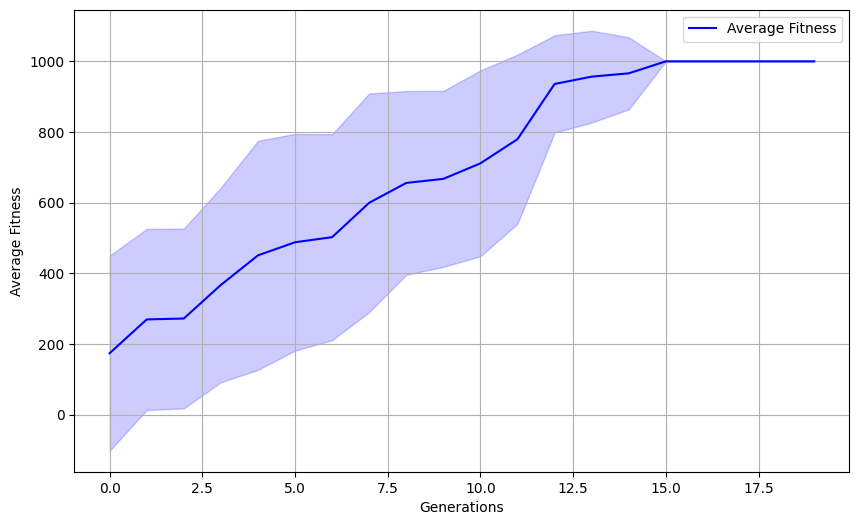

(array([ 174. ,  269.6,  272.2,  367.2,  450.9,  488. ,  502.4,  599.7,
         655.9,  667.4,  711.4,  779.8,  935.9,  956.7,  966. , 1000. ,
        1000. , 1000. , 1000. , 1000. ]),
 array([275.93078842, 256.10669652, 254.4066823 , 275.35751306,
        324.12819995, 306.69952722, 291.46258765, 309.36452609,
        259.99709614, 249.0510791 , 263.04341847, 239.18227359,
        137.71888033, 129.9       , 102.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]))

In [335]:
avg_fitness, std_fitness, _ = run_experiment(population_size, p_crossover, m_rate)
generate_subplot_function(avg_fitness, std_fitness)
avg_fitness, std_fitness


---
**Question 4 (0-0.25-0.5 pt):** Please comment on the average behavior of your algorithm. How did the average results and standard deviations look? Did your algorithm converge all the time to the best fitness?

**Answer:** The average fitness after 15 generations is 1000. This means that every run the algorithm succesfully converges to the target fitness before the simulation ends. The standard deviation remained between 250 - 300 throughout the first generations, but eventually began to narrow down after 12 generations.